## Jupyter notebook demonstrating the creation of a Keras model and training it

Import the necessary libraries
* numpy is the mathematical library
* sys gives access to operating system calls
* matplotlib is needed for plotting. This allows to better understand the dataset we are using
* tensorflow contains all the AI algorithms we are going to use

In [1]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2025-09-23 12:31:49.708077: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-23 12:31:49.708213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-23 12:31:49.777786: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-23 12:31:49.904352: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-23 12:31:52.474003: W tensorflow/compiler/tf2

Check the version numbers of python and tensorflow

In [2]:
print("Version number of python: ",sys.version)
print("Tensorflow version number: ",tf.__version__)

Version number of python:  3.10.18 (main, Jun  4 2025, 08:56:00) [GCC 13.3.0]
Tensorflow version number:  2.15.0


Check if GPU is seen

Ask tensorflow to dynamically allocate GPU memory and take only the amount it needs.
This should avoid the 'GPU memory full' error

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu,True)
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


2025-09-23 12:33:21.890845: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3503 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 950M, pci bus id: 0000:01:00.0, compute capability: 5.0


### Get the training data 

keras is the library used to create neural networks. It supplies a number of datasets to be used for testing 

mnist is a dataset with handwritten digits 
* x_train corresponds to the features
* y_train are the labels

In [4]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()

## Try to figure out what the structure and meaning of the data is

In [5]:
print(type(x_train))
print(x_train.shape)

<class 'numpy.ndarray'>
(60000, 28, 28)


In [6]:
print(type(x_train[0,0,0]))

<class 'numpy.uint8'>


Tensorflow prefers values between 0 and 1 as its inputs

In [7]:
x_train = x_train / 255.  # normalize pixel values to 0-1
x_train = x_train.astype(np.float32)

In [8]:
print(type(x_train[0][0][0]))

<class 'numpy.float32'>


In [9]:
print(type(y_train))
print(y_train.shape)

<class 'numpy.ndarray'>
(60000,)


In [10]:
print(type(y_train[0]))

<class 'numpy.uint8'>


We see that there are 60000 images of 28x28 pixels of type uint8, which we converted into float32
and there are 60000 uint8 labels

Let's try to plot the first digit using defaults parameters to imshow

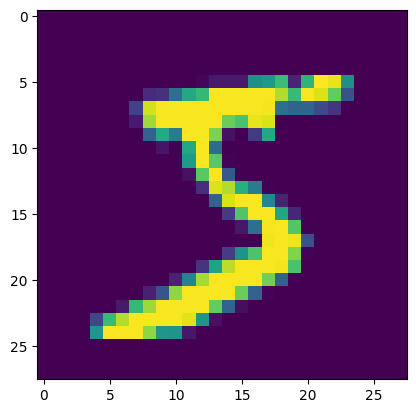

In [11]:
plt.imshow(x_train[0])

The pixel values are grey levels. These are plotted with pseudo colors using the 'viridis' color map

We can also plot the first 64 digits now using 'greys' color map 

<Figure size 640x480 with 0 Axes>

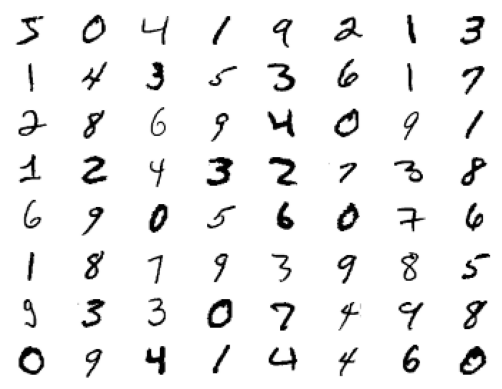

In [12]:
plt.set_cmap('Greys')
fig, axs = plt.subplots(8,8)
for i in range(8):
    for j in range(8):
        axs[i,j].axis('off')
        axs[i,j].imshow(x_train[8*i+j])

Now we can have a look at the labels. Here we expect numbers between 0 and 9. By looking at the histogram of the labels (y_train) we can see how many samples of each digit is available in the dataset. In order to get a non-biased model the numbers for each digit should be approximately equal.

(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

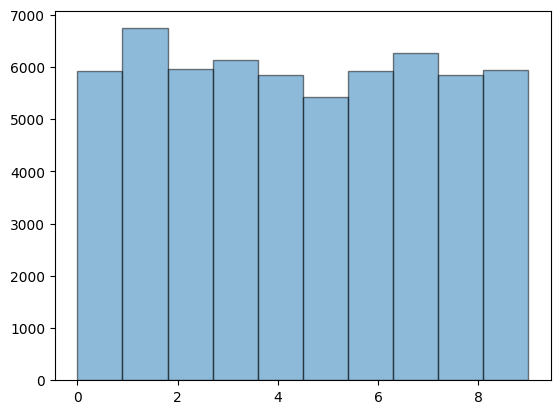

In [13]:
plt.hist(y_train,alpha=0.5, edgecolor='black')

As could be expected, we find 10 different values in the labels array. In the histogram you see how often
the numbers 0 .. 9 appear.

Now we can start creating the model

In [14]:
units = 20
model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(28, 28), name="input"),
      tf.keras.layers.LSTM(units, return_sequences=True),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax, name="output")
  ])

2025-09-23 12:42:29.656457: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 5.0
2025-09-23 12:42:29.656506: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-09-23 12:42:29.656627: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


In [16]:
model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 28, 20)            3920      
                                                                 
 flatten (Flatten)           (None, 560)               0         
                                                                 
 output (Dense)              (None, 10)                5610      
                                                                 
Total params: 9530 (37.23 KB)
Trainable params: 9530 (37.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


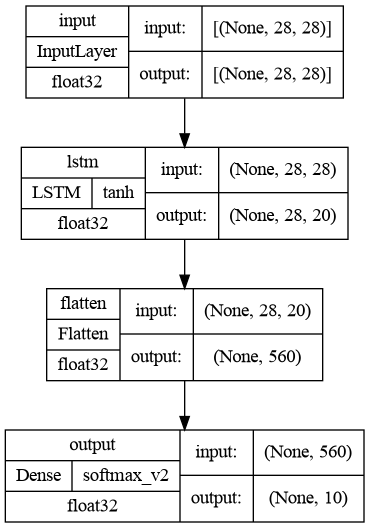

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_activations=True)

In [18]:
callback = tf.keras.callbacks.EarlyStopping(
      monitor="val_loss",
      patience=3)  # early stop if validation loss does not drop anymore

Train le model taking 20% of the data as validation data and 80% for training

In [19]:
history = model.fit(
    x_train,
    y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=32,
    callbacks=[callback])

Epoch 1/20


2025-09-23 12:44:34.524983: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-09-23 12:44:34.769287: I external/local_xla/xla/service/service.cc:168] XLA service 0x6ffca19f52a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-23 12:44:34.769340: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 950M, Compute Capability 5.0
2025-09-23 12:44:34.788180: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1758624274.910247   10777 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 [==============================] - 21s 11ms/step - loss: 0.3907 - accuracy: 0.8848 - val_loss: 0.1779 - val_accuracy: 0.9459
Epoch 2/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.1499 - accuracy: 0.9539 - val_loss: 0.1242 - val_accuracy: 0.9624
Epoch 3/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.1058 - accuracy: 0.9674 - val_loss: 0.0988 - val_accuracy: 0.9703
Epoch 4/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0854 - accuracy: 0.9734 - val_loss: 0.0867 - val_accuracy: 0.9739
Epoch 5/20
1500/1500 [==============================] - 16s 10ms/step - loss: 0.0719 - accuracy: 0.9776 - val_loss: 0.0834 - val_accuracy: 0.9745
Epoch 6/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0637 - accuracy: 0.9797 - val_loss: 0.0738 - val_accuracy: 0.9775
Epoch 7/20
1500/1500 [==============================] - 17s 11ms/step - loss: 0.0578 - accuracy: 0.9815 - val_loss: 0.0727 - val_accura

In [20]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
epochs = range(1,len(history.history['loss'])+1)
loss = history.history['loss']
val_loss = history.history['val_loss']

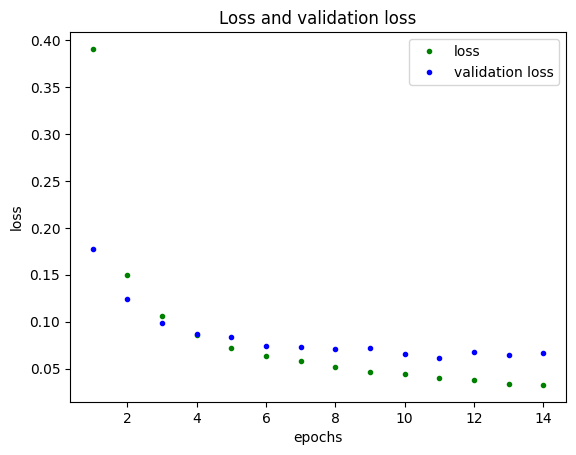

In [22]:
plt.plot(epochs,loss,'g.',label='loss')
plt.plot(epochs,val_loss,'b.',label='validation loss')
plt.title('Loss and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

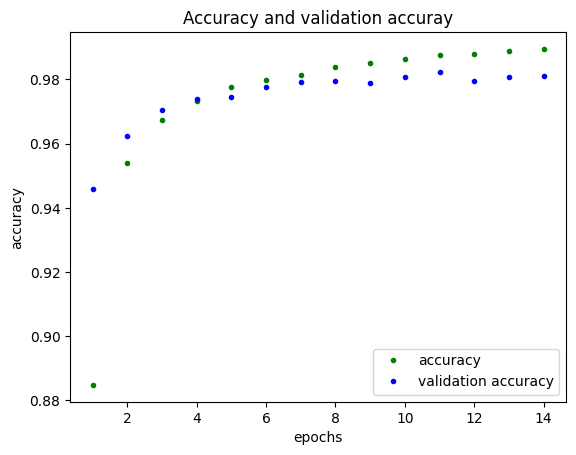

In [24]:
plt.plot(epochs,accuracy,'g.',label='accuracy')
plt.plot(epochs,val_accuracy,'b.',label='validation accuracy')
plt.title('Accuracy and validation accuray')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

The accuracy is over 98% which looks pretty nice

Prepare the trained model with fixed input tensor size for inference

In [25]:
print(model.inputs[0].dtype)

<dtype: 'float32'>


In [26]:
fixed_input =  tf.keras.layers.Input(shape=[28, 28],
                                      batch_size=1,
                                      dtype=model.inputs[0].dtype,
                                      name="fixed_input")
fixed_output = model(fixed_input)
run_model = tf.keras.models.Model(fixed_input, fixed_output)

Now we can save the tensorflow model

In [27]:
run_model.save("models",save_format="tf")

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


Convert the tensorflow model into a tflite model

In [28]:
print(help(tf.lite.TFLiteConverter))

Help on class TFLiteConverterV2 in module tensorflow.lite.python.lite:

class TFLiteConverterV2(TFLiteFrozenGraphConverterV2)
 |  TFLiteConverterV2(funcs, trackable_obj=None)
 |  
 |  Converts a TensorFlow model into TensorFlow Lite model.
 |  
 |  Attributes:
 |    optimizations: Experimental flag, subject to change. Set of optimizations to
 |      apply. e.g {tf.lite.Optimize.DEFAULT}. (default None, must be None or a
 |      set of values of type `tf.lite.Optimize`)
 |    representative_dataset: A generator function used for integer quantization
 |      where each generated sample has the same order, type and shape as the
 |      inputs to the model. Usually, this is a small subset of a few hundred
 |      samples randomly chosen, in no particular order, from the training or
 |      evaluation dataset. This is an optional attribute, but required for full
 |      integer quantization, i.e, if `tf.int8` is the only supported type in
 |      `target_spec.supported_types`. Refer to `tf.

In [29]:
converter = tf.lite.TFLiteConverter.from_keras_model(run_model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp9xieeno0/assets


INFO:tensorflow:Assets written to: /tmp/tmp9xieeno0/assets
2025-09-23 12:52:05.453116: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-09-23 12:52:05.453152: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-09-23 12:52:05.454112: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp9xieeno0
2025-09-23 12:52:05.469164: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-09-23 12:52:05.469210: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp9xieeno0
2025-09-23 12:52:05.498093: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-09-23 12:52:05.510290: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-09-23 12:52:05.668550: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

In [ ]:
tf.lite.experimental.Analyzer.analyze(model_content=tflite_model)

In [30]:
print(type(tflite_model))

<class 'bytes'>


Save the tflite model. This is simply a byte array

In [31]:
save_path = "models/number_model.tflite"
with open(save_path, "wb") as f:
    f.write(tflite_model)

Finally quantize the model to int8 format

In [32]:
def representative_dataset_gen(num_samples=100):
    for data in x_train[:num_samples]:
        yield [data.reshape(1, 28, 28)]

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(run_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = representative_dataset_gen
int8_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp7yfiwf5v/assets


INFO:tensorflow:Assets written to: /tmp/tmp7yfiwf5v/assets
/home/uli/.virtualenvs/AI/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-09-23 12:54:03.251873: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-09-23 12:54:03.251909: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-09-23 12:54:03.252152: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp7yfiwf5v
2025-09-23 12:54:03.267872: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-09-23 12:54:03.267905: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp7yfiwf5v
2025-09-23 12:54:03.316722: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-09-23 12:54

In [34]:
save_path = ("models/number_model_quantized.tflite")
with open(save_path, "wb") as f:
    f.write(int8_tflite_model)